# **AdvDSI - Assignment 2: Multi-Class Classification - Beer Style Predictor - Train - Catboost**

Train a machine learning model (using sklearn) or a custom neural networks (using pytorch) that will 

accurately predict a type of beer based on some users’ rating criterias such as appearance, aroma, palate or taste. 

You will also need to build a web app and deploy it online (using Heroku) in order to serve your model for real time predictions.

**Student Name:** Nathan Fragar

**Student No. :** 93087548

**Week:** 6

**Date:** 20MAR2022

**Notebook:** This notebook is investigating the effectiveness of the Catboost Algorithm for predicting beer type

## Install Pre-requisites
1.   Set Google Colab Notebook to use GPU Hardware accelerator

          `Edit > Notebook Settings > Hardware Accelerator = GPU`
2.   Install Catboost that can run on a Google Colab GPU
3.   Import Libraries


In [ ]:
cd /notebooks

/notebooks


In [ ]:
ls 

catboost-hyperopt-log.txt  notebooks/
catboost_info/             nvidia-docker_1.0.1-1_amd64.deb
data/                      nvidia-docker_1.0.1-1_amd64.deb.1
file_save.ipynb            nvidia-docker_1.0.1-1_amd64.deb.2
model/                     nvidia-docker_1.0.1-1_amd64.deb.3
models/


In [ ]:
! pip install catboost
! pip install hpsklearn
! pip install colorama
! pip install shap
! pip install lime

In [ ]:
# Import packages and libraries

# Pandas Numpy
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
from scipy import stats
from joblib import dump 
from joblib import load


# Hyperparameter tuning
from hpsklearn import HyperoptEstimator, any_classifier
import hyperopt
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

# Performance
from sklearn.metrics import accuracy_score
import sklearn
import shap

# Visualisation
import colorama
from lime.lime_tabular import LimeTabularExplainer

# Task: Import Scaler
from sklearn.preprocessing import MinMaxScaler

# Algorithm - Catboos
import catboost
from catboost import *
from catboost import CatBoostClassifier
from catboost import Pool

# Task: Import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


**[Task]** Change Notebook directory

In [ ]:
cd ..

/notebooks


In [ ]:
pwd

'/notebooks'

In [ ]:
ls -al

total 8882
drwxrwxrwx 8 root root      12 Mar 17 07:21 ./
drwxr-xr-x 1 root root    4096 Mar 17 07:19 ../
-rw-r--r-- 1 root root   14697 Mar 15 12:13 catboost-hyperopt-log.txt
drwxr-xr-x 5 root root       7 Mar 13 06:54 catboost_info/
drwxr-xr-x 6 root root       4 Mar 14 09:09 data/
-rw-r--r-- 1 root root   11498 Mar 13 11:37 file_save.ipynb
drwxr-xr-x 2 root root       1 Mar 13 11:37 .ipynb_checkpoints/
drwxr-xr-x 2 root root       0 Mar 13 06:10 model/
drwxr-xr-x 2 root root       1 Mar 14 10:46 models/
drwxr-xr-x 3 root root      14 Mar 17 07:23 notebooks/
-rw-r--r-- 1 root root 2266050 Dec  8 03:30 nvidia-docker_1.0.1-1_amd64.deb
-rw-r--r-- 1 root root 2266050 Dec  8 03:30 nvidia-docker_1.0.1-1_amd64.deb.1
-rw-r--r-- 1 root root 2266050 Dec  8 03:30 nvidia-docker_1.0.1-1_amd64.deb.2
-rw-r--r-- 1 root root 2266050 Dec  8 03:30 nvidia-docker_1.0.1-1_amd64.deb.3


**[Task]** Load Datasets

In [ ]:
file_path_X_train = "/notebooks/data/processed/standard_10/X_train.npy"
file_path_y_train = "/notebooks/data/processed/standard_10/y_train.npy"
file_path_X_val = "/notebooks/data/processed/standard_10/X_val.npy"
file_path_y_val = "/notebooks/data/processed/standard_10/y_val.npy"
file_path_X_test = "/notebooks/data/processed/standard_10/X_test.npy"
file_path_y_test = "/notebooks/data/processed/standard_10/y_test.npy"

# Load files into df_training and df_validation Numpy Arrays
X_train = np.load(file_path_X_train, allow_pickle=True)
y_train = np.load(file_path_y_train, allow_pickle=True)
X_val = np.load(file_path_X_val, allow_pickle=True)
y_val = np.load(file_path_y_val, allow_pickle=True)
X_test = np.load(file_path_X_test, allow_pickle=True)
y_test = np.load(file_path_y_test, allow_pickle=True)


In [ ]:
X_train.shape

(95196, 6)

In [ ]:
print(X_train)

[[1.9200e+02 1.2116e-01 7.5000e-01 9.0000e-01 8.7500e-01 8.7500e-01]
 [3.9200e+02 9.6897e-02 6.2500e-01 8.0000e-01 7.5000e-01 7.5000e-01]
 [8.1100e+02 9.6897e-02 7.5000e-01 7.0000e-01 7.5000e-01 7.5000e-01]
 ...
 [7.8400e+02 1.3677e-01 7.5000e-01 8.0000e-01 7.5000e-01 8.7500e-01]
 [7.6000e+01 9.5164e-02 5.0000e-01 8.0000e-01 7.5000e-01 7.5000e-01]
 [5.9000e+02 9.5164e-02 7.5000e-01 8.0000e-01 6.2500e-01 7.5000e-01]]


In [ ]:
print(y_train)

[ 12 102  18 ...  17  81  60]


## 2. Base Line Model

Calculate baseline accuracy

In [ ]:
vals, counts = np.unique(y_train, return_counts=True)

y_mode_num = np.argwhere(counts == np.max(counts))

y_mode = vals[y_mode_num].flatten().tolist()

print(y_mode)

[12]


In [ ]:
y_shape = (len(y_train), 1)
y_base = np.full(y_shape, y_mode)

In [ ]:
accuracy_score(y_train, y_base)

0.0741102567334762

Our null accuracy is 7.4%. 

If we predict 'American IPA', we'll be correct 7.4% of the time.

## Train Catboost Algorithm

In [ ]:
# cat_features  = Brewery Name
#cat_features = [0]

In [ ]:
train_data = Pool(
                    data=X_train
                  , label = y_train
                 )

eval_dataset = Pool(
                    data=X_val
                  , label = y_val
                 )

test_dataset = Pool(
                    data=X_test
                  , label = y_test
                 )

Multiclass CLassifier - Eval Metrics
* Logloss
* F1
* Accuracy

In [ ]:
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [ ]:
# Calculate Catboost - Check GPU
from catboost import CatBoostClassifier
model = CatBoostClassifier(
      iterations=30
    , learning_rate=0.2
    , depth = 10
    , loss_function='MultiClass'
    , task_type="GPU"
)

In [ ]:
model.fit(train_data)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

0:	learn: 3.9936089	total: 1.25s	remaining: 36.3s
1:	learn: 3.7843863	total: 2.46s	remaining: 34.5s
2:	learn: 3.6580814	total: 3.7s	remaining: 33.3s
3:	learn: 3.5689413	total: 4.91s	remaining: 31.9s
4:	learn: 3.3994371	total: 6.1s	remaining: 30.5s
5:	learn: 3.2970490	total: 7.29s	remaining: 29.2s
6:	learn: 3.2017400	total: 8.45s	remaining: 27.8s
7:	learn: 3.1371128	total: 9.62s	remaining: 26.4s
8:	learn: 3.0876737	total: 10.8s	remaining: 25.2s
9:	learn: 3.0468875	total: 12s	remaining: 24.1s
10:	learn: 3.0079986	total: 13.3s	remaining: 22.9s
11:	learn: 2.9839148	total: 14.5s	remaining: 21.8s
12:	learn: 2.9622450	total: 15.7s	remaining: 20.5s
13:	learn: 2.9444324	total: 16.8s	remaining: 19.2s
14:	learn: 2.8531418	total: 18s	remaining: 18s
15:	learn: 2.7854542	total: 19.2s	remaining: 16.8s
16:	learn: 2.7347752	total: 20.4s	remaining: 15.6s
17:	learn: 2.6728168	total: 21.6s	remaining: 14.4s
18:	learn: 2.6461608	total: 22.7s	remaining: 13.1s
19:	learn: 2.6258852	total: 24s	remaining: 12s
20

In [ ]:
# Get predicted classes
preds_class = model.predict(eval_dataset)

In [ ]:
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)

In [ ]:
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_dataset,
                          prediction_type='RawFormulaVal')

In [ ]:
print(model.get_best_score())

{'learn': {'MultiClass': 2.4066810186352368}}


In [ ]:
# Get Model with Best Iteration Score
print(model.get_params())

{'iterations': 30, 'learning_rate': 0.2, 'depth': 10, 'loss_function': 'MultiClass', 'task_type': 'GPU'}


## Model Comparison

In [ ]:
# Create pools for catboost configuration

train_data1 = Pool(
                    data=X_train
                  , label = y_train
                  , cat_features = cat_features
                 )

eval_dataset1 = Pool(
                    data=X_val
                  , label = y_val
                  , cat_features = cat_features
                 )

test_dataset1 = Pool(
                    data=X_test
                  , label = y_test
                  , cat_features = cat_features
                 )

In [ ]:
# Check learning rate between 0.01 and 0.7 to assist with understanding which end to work through
from catboost import CatBoostClassifier
model1 = CatBoostClassifier(
      iterations=100
    , learning_rate=0.7
    , depth = 10
    , loss_function='MultiClass'
    , random_seed=8
    , task_type="GPU"
    , train_dir='data/processed/catboost_10/learing_rate_0.7'
)

model2 = CatBoostClassifier(
      iterations=100
    , learning_rate=0.01
    , depth = 10
    , loss_function='MultiClass'
    , random_seed=8
    , task_type="GPU"
    , train_dir='data/processed/catboost_10/learing_rate_0.01'
)



In [ ]:
model1.fit(train_data1)
print('Model is fitted: ' + str(model1.is_fitted()))
print('Model params:')
print(model1.get_params())

0:	learn: 7.4549167	total: 1.24s	remaining: 2m 2s
1:	learn: 122.7575318	total: 2.48s	remaining: 2m 1s
2:	learn: 132.1236607	total: 3.7s	remaining: 1m 59s
3:	learn: 196.7856633	total: 4.94s	remaining: 1m 58s
4:	learn: 225.1364553	total: 6.17s	remaining: 1m 57s
5:	learn: 255.8165889	total: 7.39s	remaining: 1m 55s
6:	learn: 268.8214001	total: 8.65s	remaining: 1m 54s
7:	learn: 249.8037943	total: 9.9s	remaining: 1m 53s
8:	learn: 227.2701374	total: 11.2s	remaining: 1m 52s
9:	learn: 204.7495273	total: 12.4s	remaining: 1m 51s
10:	learn: 225.2398210	total: 13.6s	remaining: 1m 50s
11:	learn: 235.8132905	total: 14.9s	remaining: 1m 49s
12:	learn: 222.9627715	total: 16.2s	remaining: 1m 48s
13:	learn: 211.6460986	total: 17.4s	remaining: 1m 47s
14:	learn: 211.6242279	total: 18.7s	remaining: 1m 45s
15:	learn: 211.4810496	total: 20s	remaining: 1m 44s
16:	learn: 217.6911845	total: 21.2s	remaining: 1m 43s
17:	learn: 217.0951721	total: 22.5s	remaining: 1m 42s
18:	learn: 200.5099584	total: 23.7s	remaining:

In [ ]:
model2.fit(train_data1)
print('Model is fitted: ' + str(model2.is_fitted()))
print('Model params:')
print(model2.get_params())

0:	learn: 4.5908317	total: 1.22s	remaining: 2m 1s
1:	learn: 4.5465878	total: 2.44s	remaining: 1m 59s
2:	learn: 4.5092825	total: 3.7s	remaining: 1m 59s
3:	learn: 4.4739400	total: 4.94s	remaining: 1m 58s
4:	learn: 4.4395070	total: 6.12s	remaining: 1m 56s
5:	learn: 4.4086181	total: 7.34s	remaining: 1m 55s
6:	learn: 4.3779741	total: 8.49s	remaining: 1m 52s
7:	learn: 4.3497268	total: 9.65s	remaining: 1m 50s
8:	learn: 4.3234931	total: 10.9s	remaining: 1m 49s
9:	learn: 4.2993058	total: 12.1s	remaining: 1m 49s
10:	learn: 4.2756651	total: 13.3s	remaining: 1m 47s
11:	learn: 4.2553268	total: 14.6s	remaining: 1m 47s
12:	learn: 4.2341715	total: 15.8s	remaining: 1m 45s
13:	learn: 4.2137472	total: 17s	remaining: 1m 44s
14:	learn: 4.1947807	total: 18.3s	remaining: 1m 43s
15:	learn: 4.1765982	total: 19.5s	remaining: 1m 42s
16:	learn: 4.1587343	total: 20.7s	remaining: 1m 41s
17:	learn: 4.1414499	total: 21.9s	remaining: 1m 39s
18:	learn: 4.1250561	total: 23.1s	remaining: 1m 38s
19:	learn: 4.1087004	total

In [ ]:
! pip install ipywidgets

In [ ]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from catboost import MetricVisualizer

Visualise two Models

In [ ]:
MetricVisualizer(['data/processed/catboost_10/learing_rate_0.01', 'data/processed/catboost_10/learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Issue** Visualisation did not work

## Optimise Catboost with HyperOpt

In [ ]:
# Create pools for processing catboost using HyperOpt
train_data4 = Pool(
                    data=X_train
                  , label = y_train
                 )

eval_dataset4 = Pool(
                    data=X_val
                  , label = y_val
                 )

test_dataset4 = Pool(
                    data=X_test
                  , label = y_test
                )

In [ ]:
N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest

In [ ]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    return params

In [ ]:
obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [ ]:
def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = CatBoostClassifier( iterations=100,
                                learning_rate=params['learning_rate'],
                                depth=int(params['depth']),
                                loss_function='MultiClass',
                                use_best_model=True,
                                task_type="GPU",
                                #eval_metric='F1',
                                l2_leaf_reg=params['l2_leaf_reg'],
                                early_stopping_rounds=30,
                                verbose=False
                                )

    model.fit(train_data4, eval_set=eval_dataset4, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(eval_dataset4)
    test_loss = sklearn.metrics.log_loss(eval_dataset4.get_label(), y_pred)
    acc = sklearn.metrics.accuracy_score(eval_dataset4.get_label(), np.argmax(y_pred, axis=1))
    #auc = sklearn.metrics.roc_auc_score(eval_dataset4.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} Params:{} nb_trees={}\n'.format(test_loss, acc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

In [ ]:
space = {
        'depth': hp.quniform("depth", 1, 10, 2),
        'learning_rate' : hp.quniform('learning_rate', 0.1, 0.45, 0.05),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')       

                                                      
CatBoost objective call #61 cur_best_loss=2.35771
Params: depth=8.0 l2_leaf_reg=3.327477819460049 learning_rate=0.25
nb_trees=100                                          
NEW BEST LOSS=2.2274805505619084            
                                                                                
CatBoost objective call #62 cur_best_loss=2.22748
Params: depth=6.0 l2_leaf_reg=7.789753896297718 learning_rate=0.15000000000000002
nb_trees=100                                                                    
                                                                                
CatBoost objective call #63 cur_best_loss=2.22748
Params: depth=4.0 l2_leaf_reg=3.4586038967773276 learning_rate=0.25             
nb_trees=100                                                                    
                                                                                
CatBoost objective call #64 cur_best_loss=2.22748
Params: de

In [ ]:
print("Best: ", best)

Best:  {'border_count': 103.13861460449897, 'depth': 6.0, 'l2_leaf_reg': 5.493351474911527, 'learning_rate': 0.30000000000000004}


In [ ]:
 # Create best model 5
    model5 = CatBoostClassifier( iterations=100,
                                learning_rate=0.25,
                                depth=6,
                                loss_function='MultiClass',
                                use_best_model=True,
                                task_type="GPU",
                                #eval_metric='F1',
                                l2_leaf_reg=5,
                                early_stopping_rounds=30,
                                #border_count=125,
                                verbose=False, 
                                train_dir='data/processed/catboost_10/model5'
                                )

In [ ]:
# Fit and evaluate model
model5.fit(train_data4, eval_set=eval_dataset4, verbose=False)

nb_trees = model5.tree_count_

print('nb_trees={}'.format(nb_trees))

y_pred = model5.predict_proba(eval_dataset4)
test_loss = sklearn.metrics.log_loss(eval_dataset4.get_label(), y_pred)
acc = sklearn.metrics.accuracy_score(eval_dataset4.get_label(), np.argmax(y_pred, axis=1))
#auc = sklearn.metrics.roc_auc_score(eval_dataset4.get_label(), y_pred[:,1])

log_writer.write('loss={:<7.5f} acc={} nb_trees={}\n'.format(test_loss, acc, nb_trees ))
log_writer.flush()


nb_trees=100


In [ ]:
test_loss

2.4601216032586684

In [ ]:
model5.get_feature_importance(data=None,
                       reference_data=None,
                       type=EFstrType.FeatureImportance,
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

,Feature Id,Importances
0,1,63.192964
1,0,24.629285
2,2,6.342161
3,3,4.579032
4,5,0.674004
5,4,0.582554


**Feature Importance**
* 1 - beer_abv (63.2)
* 0 - brewery_id (24.6)
* 2 - review_aroma (6.3)
* 3 - review_appearance (4.6)
* 5 - review_taste (0.7)
* 4 - review_palate (0.6)

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model5)
shap_values = explainer.shap_values(Pool(X_train, y_train))

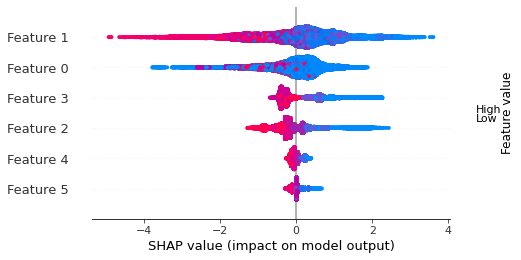

In [ ]:
# visualize the first prediction's explanation
shap.summary_plot(shap_values[1], X_train)

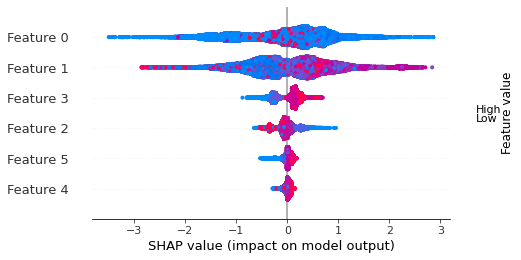

In [ ]:
# visualize the first prediction's explanation
shap.summary_plot(shap_values[0], X_train)

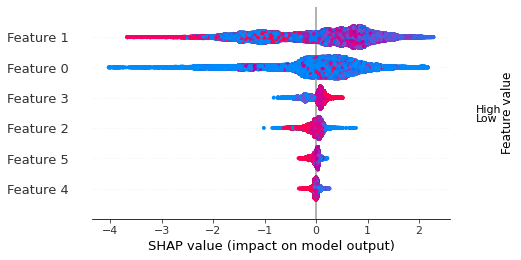

In [ ]:
# visualize the first prediction's explanation
shap.summary_plot(shap_values[2], X_train)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
r = permutation_importance(
    model5, X_train, y_train,
    n_repeats=30,
    random_state=8
)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
     print(f"{i}: {r.importances_mean[i]:.5f}")

1: 0.33468
0: 0.24136
3: 0.01892
2: 0.01683
5: 0.00317
4: 0.00180


In [ ]:
dump(model5,'models/catboost_model5.joblib')

['models/catboost_model5.joblib']

In [ ]:
model5.predict(test_dataset4,
    prediction_type='Class',
    ntree_start=0,
    ntree_end=0,
    thread_count=-1,
    verbose=None)

array([[ 9],
       [36],
       [99],
       ...,
       [ 9],
       [ 1],
       [12]])

In [ ]:
y_pred = model5.predict_proba(test_dataset4)
test_loss = sklearn.metrics.log_loss(test_dataset4.get_label(), y_pred)
acc = sklearn.metrics.accuracy_score(test_dataset4.get_label(), np.argmax(y_pred, axis=1))

In [ ]:
test_loss

2.4457597540904583

In [ ]:
acc

0.39980461979642645

#### Test Model

In [ ]:
# 11
df_test_record = [13014,0.121900,0.750,1.0,1.000,0.875]

In [ ]:
model5.predict(df_test_record,prediction_type='Class',verbose=1)

array([12])

In [ ]:
# 14
df_test_record_kolsh = [743,0.096897,0.625,0.8,0.625,0.625]

In [ ]:
# Kolsh
model5.predict(df_test_record_kolsh,prediction_type='Class')

array([17])

In [ ]:
#89 
df_test_record_belgian = [11031,0.176634,0.750,0.9,1.000,0.750]
model5.predict(df_test_record_belgian,prediction_type='Class')

array([89])

In [ ]:
# 25
df_test_record_weitbier = [694,0.190501,0.875,0.8,0.750,0.750]
model5.predict(df_test_record_weitbier,prediction_type='Class')

array([25])

## Build Pipeline

Assess building pipeline to deploy to Fast API platform

Min Max Scaling did not lend the pipeline to deployment on the Fast API model

This was due to not being able to minmax scale.

In [ ]:
df_train_pipeline = pd.DataFrame(X_train, columns = ['brewery_id','beer_abv','review_aroma','review_appearance','review_palate','review_taste'])
df_val_pipeline = pd.DataFrame(X_val, columns = ['brewery_id','beer_abv','review_aroma','review_appearance','review_palate','review_taste'])
df_test_pipeline = pd.DataFrame(X_test, columns = ['brewery_id','beer_abv','review_aroma','review_appearance','review_palate','review_taste'])

In [ ]:
df_train_pipeline['brewery_id'] = df_train_pipeline['brewery_id'].astype(int)
df_val_pipeline['brewery_id'] = df_val_pipeline['brewery_id'].astype(int)
df_test_pipeline['brewery_id'] = df_test_pipeline['brewery_id'].astype(int)

In [ ]:
df_train_pipeline.describe()

,brewery_id,beer_abv,review_aroma,review_appearance,review_palate,review_taste
count,95196.000000,95196.000000,95196.000000,95196.000000,95196.00000,95196.000000
mean,3166.500630,0.121878,0.683827,0.768432,0.68618,0.698657
std,5607.113775,0.039352,0.174153,0.122968,0.17053,0.182448
min,1.000000,0.000693,0.000000,0.200000,0.00000,0.000000
25%,143.000000,0.091697,0.625000,0.700000,0.62500,0.625000
50%,433.000000,0.115271,0.750000,0.800000,0.75000,0.750000
75%,2432.000000,0.145432,0.750000,0.800000,0.75000,0.875000
max,27927.000000,0.710522,1.000000,1.000000,1.00000,1.000000


In [ ]:
df_train_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95196 entries, 0 to 95195
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brewery_id         95196 non-null  int64  
 1   beer_abv           95196 non-null  float64
 2   review_aroma       95196 non-null  float64
 3   review_appearance  95196 non-null  float64
 4   review_palate      95196 non-null  float64
 5   review_taste       95196 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.4 MB


In [ ]:
df_train_target = pd.DataFrame(y_train, columns = ['beer_style_cat'])
df_eval_target = pd.DataFrame(y_val, columns = ['beer_style_cat'])
df_test_target = pd.DataFrame(y_test, columns = ['beer_style_cat'])

In [ ]:
train_data6 = Pool(
                    data=df_train_pipeline
                  , label = df_train_target
                 )

eval_dataset6 = Pool(
                    data=df_val_pipeline
                  , label = df_eval_target
                 )

test_dataset6 = Pool(
                    data=df_test_pipeline
                  , label = df_test_target
                )

In [ ]:
model_pipeline = CatBoostClassifier( iterations=100,
                                learning_rate=0.25,
                                depth=6,
                                loss_function='MultiClass',
                                l2_leaf_reg=5,
                                early_stopping_rounds=30,
                                verbose=False
                                )

In [ ]:
# Load saved catboost model into cb_model
cb_model_saved = load('models/catboost_model5.joblib')

In [ ]:
cb_num_cols = ['beer_abv','review_aroma','review_appearance','review_palate','review_taste']

In [ ]:
MinMaxScaleFrame(df_train_5438_65, minmax_scale_cols, inplace=True)

cols:  ['beer_abv', 'review_palate', 'review_aroma', 'review_appearance', 'review_taste']


,brewery_id,beer_abv,review_palate,review_aroma,review_appearance,review_taste
0,5438,0.086655,0.125,0.25,0.5,0.125


In [ ]:
df_train_5438_65.head()

,brewery_id,beer_abv,review_palate,review_aroma,review_appearance,review_taste,beer_abv_std,beer_abv_scaled,review_palate_std,review_palate_scaled,review_aroma_std,review_aroma_scaled,review_appearance_std,review_appearance_scaled,review_taste_std,review_taste_scaled
0,5438,5.0,1.5,2.0,2.5,1.5,0.086655,5.0,0.125,1.5,0.25,2.0,0.5,2.5,0.125,1.5


In [ ]:
# Task: Create a Pipeline called num_transformer with one step that contains MinMaxScaler
num_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler())
    ]
)

In [ ]:
# Task: Create a ColumnTransformer called preprocessor with 1 steps containing num_transformer that will be applied to num_cols
preprocessor = ColumnTransformer(
    transformers=[
        ('num_cols', num_transformer, cb_num_cols)
    ]
)

In [ ]:
# cb_pipe
cb_pipe = Pipeline(
    steps=[
        ('catboost', model_pipeline)
    ]
)

In [ ]:
cb_pipe.fit(df_train_pipeline,df_train_target)

Pipeline(steps=[('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7f2c043805e0>)])

In [ ]:
df_beer_min_max_scale = pd.read_csv('data/reference/beer_min_max_scale.csv', index_col='col')
df_beer_style = pd.read_csv('data/reference/beer_style.csv')
df_beer_brewery = pd.read_csv('data/reference/breweries.csv')

In [ ]:
df_beer_min_max_scale.head()

,min,max
col,,
review_aroma,1,5.0
review_appearance,0,5.0
review_palate,1,5.0
review_taste,1,5.0
beer_abv,0,57.7


In [ ]:
minmax_scale_cols = ['beer_abv','review_palate','review_aroma','review_appearance','review_taste']

In [ ]:
def MinMaxScaleFrame(df, cols, inplace=True):
    
    print('cols: ', cols)
    
    for col in cols:
        x_min = df_beer_min_max_scale.loc[col,'min']
        x_max = df_beer_min_max_scale.loc[col,'max']
        col_std = col + '_std'
        col_scaled = col + '_scaled'
        
        if inplace==True:
            df[col] = (df[col] - x_min)/(x_max - x_min)
        else:
            df[col_std] = (df[col] - x_min)/(x_max - x_min)
        
    return df
    

In [ ]:
# Vecchio Birraio (5438) - Hefeweizen (65)
df_train_5438_65 = pd.DataFrame([[5438,5.0,1.5,2.0,2.5,1.5]], columns = ['brewery_id','beer_abv','review_palate','review_aroma','review_appearance','review_taste'])
df_train_5438_65.head()

,brewery_id,beer_abv,review_palate,review_aroma,review_appearance,review_taste
0,5438,5.0,1.5,2.0,2.5,1.5


**Example Record:** Russian Imperial Stout (89) from Caldera Brewing Company (1075)

brewery_name,brewery_name_cat,beer_abv,review_palate,review_aroma,review_appearance,review_taste,beer_style

Caldera Brewing Company,1480,8.8,4.0,4.0,3.5,4.0,Russian Imperial Stout


In [ ]:
# Caldera Brewing Company (1075) - Russian Imperial Stout (89)
test_record_type_1480_89 = [[1480,8.8,4.0,4.0,3.5,4.0]]
test_record_type_1480_89

[[1480, 8.8, 4.0, 4.0, 3.5, 4.0]]

In [ ]:
df_train_1480_89 = pd.DataFrame(test_record_type_1480_89, columns = ['brewery_id','beer_abv','review_palate','review_aroma','review_appearance','review_taste'])

In [ ]:
df_train_1480_89.head()

,brewery_id,beer_abv,review_palate,review_aroma,review_appearance,review_taste
0,1480,8.8,4.0,4.0,3.5,4.0


In [ ]:
cb_pipe.predict(df_train_1480_89)

array([[11]])

In [ ]:
df_train_1480_89 = MinMaxScaleFrame(df_train_5438_65, minmax_scale_cols, inplace=True)

cols:  ['beer_abv', 'review_palate', 'review_aroma', 'review_appearance', 'review_taste']


In [ ]:
cb_pipe.predict(df_train_1480_89)

array([[77]])

In [ ]:
cb_model_saved.predict(df_train_1480_89)

array([[77]])

In [ ]:
# Vecchio Birraio (5438) - Hefeweizen (65)
df_train_5438_65 = pd.DataFrame([[5438,5.0,1.5,2.0,2.5,1.5]], columns = ['brewery_id','beer_abv','review_palate','review_aroma','review_appearance','review_taste'])
df_train_5438_65.head()

,brewery_id,beer_abv,review_palate,review_aroma,review_appearance,review_taste
0,5438,5.0,1.5,2.0,2.5,1.5


In [ ]:
cb_pipe.predict(df_train_5438_65)

array([[11]])

In [ ]:
df_train_5438_65 = MinMaxScaleFrame(df_train_5438_65, minmax_scale_cols, inplace=True)

cols:  ['beer_abv', 'review_palate', 'review_aroma', 'review_appearance', 'review_taste']


In [ ]:
cb_pipe.predict(df_train_5438_65)

array([[53]])

In [ ]:
cb_model_saved.predict(df_train_5438_65)

array([[53]])

In [ ]:
# Brasserie d'Orval S.A. (911) - Hefeweizen (65)
df_train_911_24 = pd.DataFrame([[911,6.9,2.0,2.0,3.0,2.5]], columns = ['brewery_id','beer_abv','review_palate','review_aroma','review_appearance','review_taste'])
df_train_911_24['brewery_id'] = df_train_911_24['brewery_id'].astype(int)
df_train_911_24.head()

,brewery_id,beer_abv,review_palate,review_aroma,review_appearance,review_taste
0,911,6.9,2.0,2.0,3.0,2.5


In [ ]:
cb_pipe.predict(df_train_911_24)

array([[11]])

In [ ]:
cb_model_saved.predict(df_train_911_24)

array([[11]])

In [ ]:
df_test_record_weitbier = [694,0.190501,0.875,0.8,0.750,0.750]

In [ ]:
# 25
cb_model_saved.predict(df_test_record_weitbier,prediction_type='Class')

array([25])

In [ ]:
cb_model_saved.predict(df_train_911_24)

array([[11]])

In [ ]:
# 392,0.09689720922170218,0.625,0.8,0.75,0.75,102
df_train_392_102 = pd.DataFrame([[392,0.09689720922170218,0.625,0.8,0.75,0.75]], columns = ['brewery_id','beer_abv','review_palate','review_aroma','review_appearance','review_taste'])
df_train_392_102['brewery_id'] = df_train_392_102['brewery_id'].astype(int)


In [ ]:
# 102: Winter Warmer (102) - Predicted: American Porter (17)
cb_model_saved.predict(df_train_392_102,prediction_type='Class')

array([[17]])

In [ ]:
# 102: Winter Warmer (102) - Predicted: American Pale Ale (APA) (14)
cb_pipe.predict(df_train_392_102)

array([[14]])

In [ ]:
# 700,0.12116484659386374,0.75,0.8,0.625,0.75,14
df_train_700_14 = pd.DataFrame([[700,0.12116484659386374,0.75,0.8,0.625,0.75]], columns = ['brewery_id','beer_abv','review_palate','review_aroma','review_appearance','review_taste'])
df_train_700_14['brewery_id'] = df_train_700_14['brewery_id'].astype(int)

In [ ]:
# Actual: American Pale Ale (APA) (14) - Predicted: American IPA (12)
cb_model_saved.predict(df_train_700_14,prediction_type='Class')

array([[12]])

In [ ]:
# Actual: American Pale Ale (APA) (14) - Predicted: American IPA (12)
cb_pipe.predict(df_train_700_14)

array([[12]])